# Conjecture 2 Counter Example

**Conjecture 2:** The absorption probability of the team optimal policy is non-decreasing with inertia (constant over agents).

In [1]:
import itertools
import numpy as np
import networkx as nx
from tqdm import tqdm

from sympy import *
from sympy.interactive import printing
from IPython.display import Math, display

import matplotlib.pyplot as plt

from br_graph_analysis import learn_br_graph, transition_matrix_from_br_graph

## Team setup 

In [2]:
# MEAN-FIELD PARAMETERS
n_states = 1 # number of states
n_actions_const = 2 # all agents have the same action spaces

def get_initial_state():
    # initial state distribution
    return np.random.choice(range(n_states)) # uniform over states for now 

init_state = 0

def transition_state(x, us):
    '''returns next state given current state and action'''
    
    # there's only one state
    return x

def mf_reward(x, u_i, mean_u):
    return np.abs(0.5 - mean_u) + 0.01*float(mean_u==0)

def gen_reward_i(i):
    def reward_i(state, actions):
        ui = actions[i]
        mean_u = np.average(actions)
        return mf_reward(state, ui, mean_u)
    
    return reward_i

beta_const = 0.9 # discount rate; constant across agents

In [3]:
n_agents = 3

# GAME PARAMS (adjusted for n-agents)
n_Us = [n_actions_const] * n_agents # number of actions per agent (both agents have two actions)
reward_funcs = [gen_reward_i(i) for i in range(n_agents)]
betas = [beta_const]*n_agents # discount factor

# LEARNING PARAMETERS
T = 50000 # length of exploration phase
experimentation_probs = [0.01]*n_agents # probability of experimentation at each action (\rho)
alpha_func = lambda n: 1/n
deltas = [1e-6]*n_agents # tolerance for suboptimality


# learn BR graph
br_graph = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
                  T, experimentation_probs, alpha_func, deltas)

100%|██████████████████████| 8/8 [01:25<00:00, 10.66s/it]


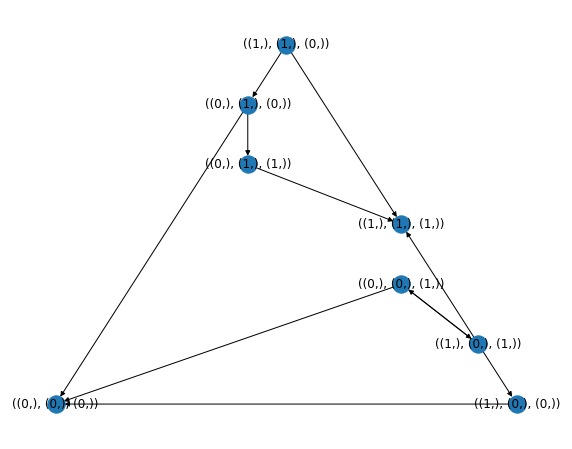

In [4]:
# draw BR graph (without self-loops)
br_graph_ = nx.DiGraph.copy(br_graph)
br_graph_.remove_edges_from(nx.selfloop_edges(br_graph_))
fig, ax = plt.subplots(figsize=(10,8))
nx.draw_planar(br_graph_, with_labels=True, ax=ax)

In [5]:
[node for node in br_graph_.nodes if br_graph_.out_degree(node) == 0]

[((0,), (0,), (0,)), ((1,), (1,), (1,))]

In [6]:
agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))

In [7]:
# BR Process Inertia PARAMETERS

# constant inertia
const_inertia = 0.1
agent_inertias = [const_inertia]*n_agents

# # different inertias
# agent_inertias = [0.99, 0.001, 0.001]

In [8]:
P_, jps_dict = transition_matrix_from_br_graph(br_graph, agent_inertias, joint_policy_space)
P_ = P_.astype(float)
P = Matrix(P_).applyfunc(nsimplify)
display(Math(f'P = {printing.default_latex(P)}')) # too big to display

<IPython.core.display.Math object>

In [9]:
P_inf_ = np.round(np.linalg.matrix_power(P_, 1000), 10)
P_inf = Matrix(P_inf_).applyfunc(nsimplify)
display(Math(f'P_\infty = {printing.default_latex(P_inf)}'))

<IPython.core.display.Math object>

In [10]:
uniform_dist = [1/len(joint_policy_space)]*len(joint_policy_space)
final_dist = Matrix(uniform_dist @ P_inf_).T.applyfunc(nsimplify)
final_dist.evalf(3)

Matrix([[0.588, 0, 0, 0, 0, 0, 0, 0.412]])

In [11]:
def Astar(agent_inertias):
    P_, jps_dict = transition_matrix_from_br_graph(br_graph, agent_inertias, joint_policy_space)
    P_ = P_.astype(float)
    
    P_inf_ = np.round(np.linalg.matrix_power(P_, 1000), 10)
    uniform_dist = [1/len(joint_policy_space)]*len(joint_policy_space)
    final_dist = uniform_dist @ P_inf_
    return final_dist[0]

In [12]:
lamdas = np.linspace(0 + 1e-2,1-1e-2, num=1000)
optimal_probs = [Astar([lamda]*n_agents) for lamda in lamdas]

In [13]:
import matplotlib.pyplot as plt

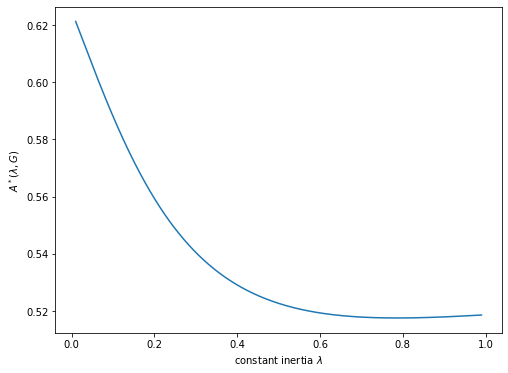

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lamdas, optimal_probs)
ax.set_xlabel('constant inertia $\lambda$')
ax.set_ylabel('$A^*(\lambda, G)$')
fig.savefig('conj2_counterexample.png')

## Sim Confirmation

In [21]:
agent_inertias = [0.5]*n_agents

# data
end_data = {p: [] for p in joint_policy_space}
transition_data = {p: [] for p in joint_policy_space}

In [23]:
# disable inner tqdm
from tqdm import tqdm
from functools import partialmethod
from multi_agent_learning import q_learning_alg1

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

n_trials = 1000

n_exploration_phases = 10000
T = 1000 # length of exploration phase
experimentation_probs = [0.05]*n_agents # probability of experimentation at each action (\rho)
alpha_func = lambda n: 1/n
deltas = [1e-2]*n_agents # tolerance for suboptimality



for _ in tqdm(range(n_trials), disable=False):
    K, Qs, agent_policies, (policy_history, Qs_history, is_BR_history) = q_learning_alg1(n_Us, n_states, reward_funcs, betas,
                                                                    get_initial_state, transition_state, 
                                                                    n_exploration_phases, T, experimentation_probs,
                                                                    alpha_func, deltas, agent_inertias, early_stopping=True)

    init_policy = tuple(policy_history[0])
    end_data[init_policy].append(tuple(agent_policies))
    
    for p1, p2 in zip(policy_history[:-1], policy_history[1:]):
        transition_data[tuple(p1)].append(tuple(p2))

100%|████████████████| 1000/1000 [09:53<00:00,  1.68it/s]


In [24]:
markov_end_prob = {p1: {} for p1 in joint_policy_space}

for p1 in joint_policy_space:
    arr = np.array(end_data[p1])
    print('initial_policy = ', p1)
    for p2 in joint_policy_space:
        P12 = np.average(np.all(arr==p2, axis=1))
        markov_end_prob[p1][p2] = P12
        print(f'prob ending at {p2} = {P12}')
    print()

initial_policy =  ((0,), (0,), (0,))
prob ending at ((0,), (0,), (0,)) = 1.0
prob ending at ((0,), (0,), (1,)) = 0.0
prob ending at ((0,), (1,), (0,)) = 0.0
prob ending at ((0,), (1,), (1,)) = 0.0
prob ending at ((1,), (0,), (0,)) = 0.0
prob ending at ((1,), (0,), (1,)) = 0.0
prob ending at ((1,), (1,), (0,)) = 0.0
prob ending at ((1,), (1,), (1,)) = 0.0

initial_policy =  ((0,), (0,), (1,))
prob ending at ((0,), (0,), (0,)) = 0.7923076923076923
prob ending at ((0,), (0,), (1,)) = 0.0
prob ending at ((0,), (1,), (0,)) = 0.0
prob ending at ((0,), (1,), (1,)) = 0.0
prob ending at ((1,), (0,), (0,)) = 0.0
prob ending at ((1,), (0,), (1,)) = 0.0
prob ending at ((1,), (1,), (0,)) = 0.0
prob ending at ((1,), (1,), (1,)) = 0.2076923076923077

initial_policy =  ((0,), (1,), (0,))
prob ending at ((0,), (0,), (0,)) = 0.7819548872180451
prob ending at ((0,), (0,), (1,)) = 0.0
prob ending at ((0,), (1,), (0,)) = 0.0
prob ending at ((0,), (1,), (1,)) = 0.0
prob ending at ((1,), (0,), (0,)) = 0.0
pr

In [25]:
# calculate frequency/probability of transitioning to each policy given a starting policy


markov_transition_prob = {p1: {} for p1 in joint_policy_space}

for p1 in joint_policy_space:
    arr = np.array(transition_data[p1])
    print('initial_policy = ', p1)
    if len(arr) > 0:
        for p2 in joint_policy_space:
            P12 = np.average(np.all(arr==p2, axis=1))
            markov_transition_prob[p1][p2] = P12
            print(f'prob transitioning to {p2} = {P12}')
    else:
        for p2 in joint_policy_space:
            P12 = 1 if p1==p2 else 0
            markov_transition_prob[p1][p2] = P12
            print(f'prob transitioning to {p2} = {P12}')
        
    print()

initial_policy =  ((0,), (0,), (0,))
prob transitioning to ((0,), (0,), (0,)) = 1
prob transitioning to ((0,), (0,), (1,)) = 0
prob transitioning to ((0,), (1,), (0,)) = 0
prob transitioning to ((0,), (1,), (1,)) = 0
prob transitioning to ((1,), (0,), (0,)) = 0
prob transitioning to ((1,), (0,), (1,)) = 0
prob transitioning to ((1,), (1,), (0,)) = 0
prob transitioning to ((1,), (1,), (1,)) = 0

initial_policy =  ((0,), (0,), (1,))
prob transitioning to ((0,), (0,), (0,)) = 0.3583815028901734
prob transitioning to ((0,), (0,), (1,)) = 0.36127167630057805
prob transitioning to ((0,), (1,), (0,)) = 0.05202312138728324
prob transitioning to ((0,), (1,), (1,)) = 0.06358381502890173
prob transitioning to ((1,), (0,), (0,)) = 0.06647398843930635
prob transitioning to ((1,), (0,), (1,)) = 0.06647398843930635
prob transitioning to ((1,), (1,), (0,)) = 0.02023121387283237
prob transitioning to ((1,), (1,), (1,)) = 0.011560693641618497

initial_policy =  ((0,), (1,), (0,))
prob transitioning to (

In [26]:
P_ = np.array([[markov_transition_prob[p1][p2] for p2 in joint_policy_space] for p1 in joint_policy_space])

In [31]:
# theoretical end probabilities
Matrix(np.linalg.matrix_power(P_, 10000)) # ~ lim T^N (N-> oo)

Matrix([
[              1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,               0.0],
[0.757377679275792, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.242622320724208],
[0.753489350071193, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.246510649928807],
[0.273599982067371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.726400017932629],
[0.736060279943468, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.263939720056532],
[ 0.22883956881522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.77116043118478],
[0.229394670248088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.770605329751912],
[              0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,               1.0]])

In [32]:
Matrix(np.array([[markov_end_prob[p1][p2] for p2 in joint_policy_space] for p1 in joint_policy_space]))

Matrix([
[              1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,               0.0],
[0.792307692307692, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.207692307692308],
[0.781954887218045, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.218045112781955],
[0.257352941176471, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.742647058823529],
[0.683453237410072, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.316546762589928],
[0.264462809917355, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.735537190082645],
[0.207142857142857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.792857142857143],
[              0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,               1.0]])

pretty close!